# Image Colorization using Autoencoder
Deep Learning model written in Pytorch to convert gray scaled images into RGB/LAB images.

## Setup
Import Libraries
Convert images to grayscale and sort them for training

In [69]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
from PIL import Image
import numpy as np
from keras import layers

import wandb
import datetime
import time
import copy

from tqdm import tqdm


In [72]:
# Define Input and Output folder for color transformation
input_folder = './color_train/'
input_color = './data/color_train/'
output_folder = './data/gray_train/'
original_bw_folder = './data/original_bw_images'
num_img_to_process = 10000000

## Load Functions

In [73]:
# Function to load and preprocess images
def load_image(image_path, color_mode='rgb', target_size=(160, 160)):
    # Load the image
    image = Image.open(image_path)
    
    # Convert color mode if necessary
    if color_mode == 'rgb':
        image = image.convert('RGB')
    elif color_mode == 'grayscale':
        image = image.convert('L')
    
    # Resize the image
    resize_transform = transforms.Resize(target_size)
    image = resize_transform(image)
    
    # Convert to tensor and normalize
    image = transforms.ToTensor()(image)  # Converts to [0, 1] range
    if color_mode == 'rgb':
        image = transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])(image)  # Normalize
    
    # Ensure grayscale images are converted to RGB format
    if color_mode == 'grayscale':
        image = image.expand(3, -1, -1)
    
    return image

## Defining Classes for sorting the input data

In [74]:
# Defining class of Image DataSet:
class ImageDataset(Dataset):
    def __init__(self, image_paths, color_mode='rgb', target_size=(160, 160)):
        self.image_paths = image_paths
        self.color_mode = color_mode
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # Open image to check if it matches the expected color mode
        with Image.open(image_path) as img:
            img_mode = img.mode
            
            if self.color_mode == 'grayscale' and img_mode != 'L':
                print(f"Warning: {image_path} is expected to be grayscale (mode 'L'), but it is {img_mode}.")
                warning_flag = True

            elif self.color_mode == 'rgb' and img_mode != 'RGB':
                print(f"Warning: {image_path} is expected to be RGB (mode 'RGB'), but it is {img_mode}.")
                warning_flag = True
            else:
                warning_flag = False
  
        # Load the image using the desired color mode
        image = load_image(image_path, color_mode=self.color_mode, target_size=self.target_size)

        if warning_flag:
            print(f"Warning - Images located incorrectly: {image_path}")

        return image

class PairedDataset(Dataset):
    def __init__(self, grayscale_dataset, color_dataset):
        assert len(grayscale_dataset) == len(color_dataset), "Datasets must have the same length."
        self.grayscale_dataset = grayscale_dataset
        self.color_dataset = color_dataset

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image = self.grayscale_dataset[idx]
        color_image = self.color_dataset[idx]
        return grayscale_image, color_image

## Preprocessing
### Loading images
Converting RGB images from input folder to grayscale images and saving them in output folder. 
Additionally, it filters out original grayscale images, saving it into "original_bw_images" folder to evaluate later on. (Ground truth unknown here)

In [75]:

# Create Output Folder if it does not exist yet
os.makedirs(input_color, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)
os.makedirs(original_bw_folder, exist_ok=True)

# Take num_img_to_process images to convert to grayscale

input_all = os.listdir(input_folder)
num_images = min(num_img_to_process, len(input_all))
image_files = [f for f in input_all[:num_images] if f.endswith(('jpg', 'jpeg', 'png'))]

print(f"Collected {len(image_files)} images in folder {input_folder}.")

# Itera su ogni immagine, convertila in grayscale e salvala
for image_file in image_files:
    input_path = os.path.join(input_folder, image_file)
    output_path = os.path.join(output_folder, image_file)
    originals_path = os.path.join(original_bw_folder, image_file)
    # Apri l'immagine e converti in grayscale
    with Image.open(input_path) as img:
        # Original Grayscale images in Coco Dataset:
        if img.mode == 'L':
            img.save(originals_path)
            os.remove(input_path)
            print(input_path)
        else:
            grayscale_img = img.convert("L")  # Converti in grayscale
            grayscale_img.save(output_path)

print(f"Images converted into grayscale and saved in {output_folder}.")


Collected 3552 images in folder ./color_train/.
Images converted into grayscale and saved in ./data/gray_train/.


## Sorting and pairing dataset

Sorting dataset to train and test on

In [76]:
# Define paths to rgb and gray scale images
color_images_path = input_folder
grayscale_images_path = output_folder

# Get sorted lists of image file paths
color_image_files = sorted([os.path.join(color_images_path, f) for f in os.listdir(color_images_path) if f.endswith(('jpg', 'png', 'jpeg'))])
grayscale_image_files = sorted([os.path.join(grayscale_images_path, f) for f in os.listdir(grayscale_images_path) if f.endswith(('jpg', 'png', 'jpeg'))])

# Ensure the filenames without paths are used for matching
color_filenames = {os.path.basename(f): f for f in color_image_files}
grayscale_filenames = {os.path.basename(f): f for f in grayscale_image_files}

# Match pairs based on filenames
paired_filenames = [(grayscale_filenames[f], color_filenames[f]) for f in grayscale_filenames if f in color_filenames]

# Check if pairs were created correctly
print(f"Number of pairs created: {len(paired_filenames)}")

# Create a dataset from the paired filenames
grayscale_paths, color_paths = zip(*paired_filenames)

grayscale_paths = list(grayscale_paths)
color_paths = list(color_paths)

# Split the dataset into train and test sets (train = 85%, test = 15%)
train_size  = int(len(grayscale_paths)*0.85)
test_size = int(len(grayscale_paths)*0.15)
print(f"train len: {train_size}, test len:{test_size}")

train_grayscale_paths = grayscale_paths[:train_size]
test_grayscale_paths = grayscale_paths[test_size:]

train_color_paths = color_paths[:train_size]
test_color_paths = color_paths[test_size:]

# Creating datasets
## train dataset
train_grayscale_ds = ImageDataset(train_grayscale_paths, color_mode='grayscale')
train_color_ds = ImageDataset(train_color_paths, color_mode='rgb')

## test dataset
test_grayscale_ds = ImageDataset(test_grayscale_paths, color_mode='grayscale')
test_color_ds = ImageDataset(test_color_paths, color_mode='rgb')

# Ensure there are no mix-ups in dataset - rgb/grayscale separation
for idx in range(len(train_grayscale_ds)):
    image = train_grayscale_ds[idx]

for idx in range(len(train_color_ds)):
    image = train_color_ds[idx] 

for idx in range(len(test_grayscale_ds)):
    image = test_grayscale_ds[idx] 

for idx in range(len(test_color_ds)):
    image = test_color_ds[idx]

# Creating data loaders
train_grayscale_loader = DataLoader(train_grayscale_ds, batch_size=32, shuffle=True, num_workers=0)
train_color_loader = DataLoader(train_color_ds, batch_size=32, shuffle=True, num_workers=0)

test_grayscale_loader = DataLoader(test_grayscale_ds, batch_size=32, shuffle=False, num_workers=0)
test_color_loader = DataLoader(test_color_ds, batch_size=32, shuffle=False, num_workers=0)

# Combine grayscale and color datasets into paired datasets
train_dataset = PairedDataset(train_grayscale_ds, train_color_ds)
test_dataset = PairedDataset(test_grayscale_ds, test_color_ds)

# DataLoader configurations
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# # Train the model using the train dataset
# model.fit(train_dataset, epochs=50, validation_data=test_dataset)


Number of pairs created: 3552
train len: 3019, test len:532


# Autoencoder
## Define model
Here we define the encoder/decoder (down/up) building blocks of the Autoencoder.
* down function reduces the spatial dimension of the input
* up function increases the spatial dimension, reconstructing the input image

In [77]:
# Down function
def down(filters, kernel_size, apply_batch_normalization=True):
    layers = []
    
    # Conv2d layer
    layers.append(nn.Conv2d(in_channels=3, out_channels=filters, kernel_size=kernel_size, stride=2, padding=1))
    
    # Batch Normalization
    if apply_batch_normalization:
        layers.append(nn.BatchNorm2d(filters))
    
    # LeakyReLU activation
    layers.append(nn.LeakyReLU(negative_slope=0.2))
    
    return nn.Sequential(*layers)


# Up function
def up(filters, kernel_size, dropout=False):
    layers = []
    
    # ConvTranspose2d layer
    layers.append(nn.ConvTranspose2d(in_channels=3, out_channels=filters, kernel_size=kernel_size, stride=2, padding=1))
    
    # Dropout
    if dropout:
        layers.append(nn.Dropout(0.2))
    
    # LeakyReLU activation
    layers.append(nn.LeakyReLU(negative_slope=0.2))
    
    return nn.Sequential(*layers)


In [78]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Downsampling layers
        self.d1 = down(128, (3, 3), False)
        self.d2 = down(128, (3, 3), False)
        self.d3 = down(256, (3, 3), True)
        self.d4 = down(512, (3, 3), True)
        self.d5 = down(512, (3, 3), True)

        # Upsampling layers
        self.u1 = up(512, (3, 3), False)
        self.u2 = up(256, (3, 3), False)
        self.u3 = up(128, (3, 3), False)
        self.u4 = up(128, (3, 3), False)
        self.u5 = up(3, (3, 3), False)

        # Final convolution layer
        self.final_conv = nn.Conv2d(6, 3, kernel_size=2, stride=1, padding=1)  # 6 channels from concatenation

    def forward(self, x):
        # Downsampling path - ENCODER
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)

        # Upsampling path -DECODER
        u1 = self.u1(d5)
        u1 = torch.cat([u1, d4], dim=1)  # Concatenate along channels
        u2 = self.u2(u1)
        u2 = torch.cat([u2, d3], dim=1)
        u3 = self.u3(u2)
        u3 = torch.cat([u3, d2], dim=1)
        u4 = self.u4(u3)
        u4 = torch.cat([u4, d1], dim=1)
        u5 = self.u5(u4)
        u5 = torch.cat([u5, x], dim=1)  # Concatenate the input image

        # Final output
        output = self.final_conv(u5)
        return output

# Instantiate the model
model = UNet()

# Print the model architecture
print(model)

UNet(
  (d1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (d2): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (d3): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (d4): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (d5): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (u1): Sequential(
    (0): ConvT

In [79]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),  # Output: (64, H/2, W/2)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), # Output: (128, H/4, W/4)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1), # Output: (256, H/8, W/8)
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (128, H/4, W/4)
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (64, H/2, W/2)
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: (3, H, W)
            nn.Sigmoid()  # Ensure pixel values are scaled between 0 and 1
        )
    
    def forward(self, x):
        # Pass input through the encoder
        encoded = self.encoder(x)
        # Pass encoded features through the decoder
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
model = AE()

# Print the architecture to verify
print(model)


AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing Model
model = AE()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                        lr=1e-4,
                        weight_decay = 1e-8)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(tqdm(train_loader), 1):
        # Move tensors to the GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        print(inputs.shape)
        print(f"targets: {targets.shape}")
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i}/{len(train_loader)}], Loss: {running_loss / i:.4f}")
    
    print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / len(train_loader):.4f}")
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        print(f"Validation Loss: {val_loss / len(test_loader):.4f}")
    
    model.train()  # Set model back to training mode

# Save the model
torch.save(model.state_dict(), "unet_model.pth")

  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:50,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:46,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:45,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:01<00:44,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:45,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:02<00:43,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:42,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:03<00:42,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:45,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:45,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:43,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:41,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:41,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:41,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:39,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:38,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:37,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:08<00:37,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:36,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:09<00:36,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:36,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:10<00:36,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:36,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:35,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:36,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:37,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:37,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:36,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:35,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:34,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:33,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:32,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:31,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:30,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:31,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:28,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:27,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:27,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:26,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:26,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:25,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:25,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:25,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:24,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:24,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:23,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:22,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:21,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:21,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:20,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:19,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:18,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:18,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:17,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:16,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:18,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:17,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:16,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:16,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:15,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:14,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:13,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:13,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:12,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:12,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:11,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:11,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:10,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:08,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:41<00:07,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:42<00:06,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:06,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:43<00:06,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:44<00:05,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:45<00:04,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:46<00:02,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:47<00:01,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:48<00:00,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.95it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [1/20], Average Loss: 1.4561
Validation Loss: 1.4513


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:47,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:00<00:45,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:55,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:50,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:49,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:48,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:47,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:46,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:44,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:42,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:43,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:42,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:41,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:41,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:41,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:40,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:40,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:41,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:40,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:39,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:38,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:38,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:37,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:37,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:37,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:35,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:35,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:37,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:36,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:35,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:17<00:33,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:33,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:18<00:32,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:32,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:19<00:31,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:30,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:20<00:30,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:31,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:21<00:30,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:22<00:30,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:29,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:23<00:28,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:27,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:24<00:26,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:25,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:25<00:24,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:24,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:26<00:24,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:23,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:27<00:22,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:22,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:28<00:21,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:21,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:20,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:19,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:19,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:19,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:21,  1.68it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:32<00:20,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:18,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:33<00:18,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:17,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:34<00:17,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:16,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:35<00:16,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:36<00:16,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:36<00:15,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:37<00:15,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:13,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:38<00:13,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:12,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:39<00:11,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:11,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:40<00:10,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:09,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:41<00:10,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:42<00:09,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:42<00:08,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:43<00:07,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:43<00:07,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:44<00:06,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:44<00:06,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:45<00:05,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:45<00:05,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:46<00:04,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:47<00:03,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:48<00:02,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:49<00:01,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:50<00:00,  1.87it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [2/20], Average Loss: 1.4542
Validation Loss: 1.4510


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:56,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:53,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:50,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:48,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:49,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:47,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:46,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:46,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:06<00:47,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:45,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:07<00:44,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:47,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:08<00:47,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:46,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:45,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:10<00:44,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:42,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:11<00:42,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:41,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:12<00:42,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:13<00:43,  1.64it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:13<00:42,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:14<00:41,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:14<00:40,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:15<00:38,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:15<00:36,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:16<00:36,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:36,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:17<00:36,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:18<00:36,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:18<00:37,  1.64it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:19<00:35,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:19<00:34,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:20<00:34,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:21<00:34,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:21<00:33,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:22<00:32,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:23<00:36,  1.50it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:24<00:39,  1.36it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:24<00:42,  1.25it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:25<00:39,  1.30it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:26<00:37,  1.37it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:26<00:33,  1.47it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:27<00:31,  1.56it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:28<00:30,  1.60it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:28<00:30,  1.56it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:29<00:29,  1.54it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:29<00:28,  1.57it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:30<00:28,  1.53it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:31<00:27,  1.55it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:31<00:25,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:32<00:23,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:32<00:22,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:33<00:20,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:33<00:20,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:34<00:19,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:34<00:19,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:35<00:19,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:35<00:18,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:36<00:18,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:37<00:17,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:37<00:17,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:38<00:16,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:38<00:15,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:39<00:14,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:39<00:14,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:40<00:13,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:40<00:13,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:41<00:12,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:41<00:11,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:42<00:11,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:42<00:11,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:43<00:10,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:43<00:10,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:44<00:09,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:45<00:08,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:45<00:08,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:46<00:08,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:46<00:08,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:47<00:08,  1.60it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:48<00:07,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:48<00:06,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:49<00:05,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:49<00:04,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:50<00:04,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:50<00:03,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:51<00:03,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:51<00:02,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:52<00:01,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:52<00:01,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:53<00:00,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:53<00:00,  1.77it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [3/20], Average Loss: 1.4530
Validation Loss: 1.4509


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:48,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:48,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:46,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:45,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:45,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:44,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:44,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:43,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:42,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:41,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:40,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:42,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:45,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:43,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:43,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:42,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:40,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:39,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:38,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:38,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:37,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:38,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:37,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:34,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:33,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:33,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:32,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:31,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:32,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:30,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:29,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:29,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:29,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:28,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:27,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:28,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:26,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:26,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:21<00:25,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:25,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:22<00:25,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:24,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:23<00:23,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:23,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:24<00:22,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:22,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:25<00:21,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:21,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:26<00:20,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:20,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:27<00:19,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:28<00:18,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:18,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:29<00:18,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:17,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:30<00:16,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:16,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:31<00:15,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:15,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:32<00:15,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:14,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:33<00:14,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:34<00:13,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:34<00:12,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:35<00:12,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:35<00:11,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:36<00:11,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:36<00:10,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:37<00:10,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:37<00:10,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:38<00:10,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:38<00:09,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:39<00:09,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:08,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:40<00:08,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:41<00:06,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:06,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:42<00:06,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:43<00:05,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:04,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:44<00:03,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:03,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:45<00:02,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:02,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:46<00:01,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.97it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [4/20], Average Loss: 1.4534
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:45,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:45,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:01<00:44,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:02<00:43,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:43,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:03<00:42,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:41,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:04<00:41,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:40,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:05<00:41,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:40,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:06<00:40,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:39,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:07<00:39,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:38,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:08<00:37,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:37,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:09<00:39,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:37,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:10<00:36,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:35,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:11<00:34,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:34,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:12<00:33,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:33,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:13<00:33,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:32,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:14<00:32,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:31,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:15<00:30,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:30,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:16<00:29,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:29,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:17<00:28,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:28,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:18<00:27,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:27,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:19<00:27,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:27,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:20<00:26,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:21<00:25,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:21<00:25,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:22<00:25,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:22<00:25,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:23<00:24,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:23<00:24,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:24<00:23,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:24<00:22,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:25<00:21,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:25<00:21,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:26<00:20,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:26<00:20,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:27<00:19,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:27<00:19,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:28<00:19,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:28<00:20,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:29<00:19,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:29<00:18,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:30<00:17,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:30<00:17,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:31<00:16,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:31<00:15,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:32<00:14,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:32<00:14,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:33<00:14,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:33<00:13,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:34<00:12,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:34<00:12,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:35<00:12,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:36<00:12,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:36<00:11,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:37<00:10,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:37<00:10,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:38<00:10,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:38<00:09,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:39<00:08,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:39<00:08,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:40<00:07,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:40<00:07,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:41<00:07,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:41<00:06,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:42<00:06,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:43<00:04,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:04,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:44<00:03,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:44<00:03,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:45<00:02,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:02,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:46<00:01,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:47<00:00,  1.99it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [5/20], Average Loss: 1.4522
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:44,  2.12it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:00<00:44,  2.11it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:43,  2.12it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:01<00:43,  2.11it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:02<00:44,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:44,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:03<00:42,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:42,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:04<00:41,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:42,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:05<00:41,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:43,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:06<00:41,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:40,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:07<00:39,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:40,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:44,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:41,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:41,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:39,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:37,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:36,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:35,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:35,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:34,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:33,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:33,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:33,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:34,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:32,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:31,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:30,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:30,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:28,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:26,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:27,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:21<00:26,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:25,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:22<00:25,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:24,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:23<00:23,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:23,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:24<00:22,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:21,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:25<00:21,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:21,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:26<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:21,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:27<00:20,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:28<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:18,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:29<00:17,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:17,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:30<00:16,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:16,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:31<00:15,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:15,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:32<00:14,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:13,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:33<00:13,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:34<00:12,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:34<00:12,  2.09it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:35<00:11,  2.12it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:35<00:12,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:36<00:11,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:36<00:11,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:37<00:10,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:37<00:10,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:38<00:09,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:38<00:09,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:39<00:08,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:39<00:08,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:40<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:40<00:07,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:41<00:06,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:41<00:05,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:42<00:05,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:42<00:04,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:43<00:04,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:43<00:04,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:44<00:03,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:03,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:45<00:02,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:02,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:46<00:01,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:47<00:00,  1.99it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [6/20], Average Loss: 1.4541
Validation Loss: 1.4509


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:47,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:45,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:46,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:45,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:43,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:42,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:41,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:40,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:05<00:40,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:39,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:06<00:39,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:38,  2.08it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:07<00:38,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:38,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:40,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:38,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:37,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:36,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:35,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:11<00:34,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:34,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:12<00:33,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:32,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:13<00:32,  2.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:33,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:14<00:32,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:32,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:15<00:31,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:31,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:33,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:33,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:32,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:30,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:28,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:26,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:25,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:21<00:25,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:25,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:22<00:24,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:24,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:23<00:23,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:23,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:24<00:23,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:22,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:25<00:23,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:22,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:26<00:21,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:20,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:27<00:20,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:28<00:19,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:18,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:29<00:17,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:17,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:30<00:17,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:17,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:17,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:17,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:16,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:16,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:15,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:34<00:14,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:14,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:14,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:13,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:12,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:11,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:11,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:10,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:09,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:09,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:08,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:07,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:06,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:06,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:45<00:04,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:46<00:03,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:47<00:02,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:48<00:01,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.94it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [7/20], Average Loss: 1.4525
Validation Loss: 1.4511


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:46,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:47,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:46,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:46,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:44,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:44,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:43,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:43,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:43,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:43,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:42,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:43,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:43,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:45,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:43,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:39,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:38,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:37,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:37,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:36,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:37,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:36,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:36,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:35,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:32,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:32,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:31,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:31,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:30,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:27,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:26,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:25,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:27,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:32,  1.53it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:34,  1.41it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:25<00:31,  1.51it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:31,  1.50it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:26<00:29,  1.58it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:27,  1.64it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:27<00:25,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:24,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:28<00:23,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:29<00:23,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:21,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:30<00:21,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:20,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:31<00:19,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:19,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:32<00:18,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:17,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:33<00:17,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:17,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:34<00:16,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:15,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:35<00:14,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:35<00:14,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:36<00:13,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:36<00:13,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:12,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:11,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:11,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:10,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:10,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:10,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:09,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:41<00:08,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:42<00:08,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:42<00:07,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:43<00:07,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:43<00:06,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:44<00:06,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:05,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:45<00:05,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:45<00:04,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:46<00:03,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:47<00:02,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:48<00:01,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:50<00:00,  1.90it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [8/20], Average Loss: 1.4533
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:51,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:48,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:48,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:47,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:46,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:44,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:45,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:45,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:44,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:43,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:44,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:43,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:42,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:40,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:40,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:39,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:40,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:39,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:38,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:36,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:35,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:35,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:34,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:33,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:33,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:33,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:32,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:30,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:31,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:30,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:31,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:30,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:30,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:29,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:28,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:27,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:26,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:25,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:24,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:23,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:22,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:22,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:22,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:21,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:21,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:20,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:20,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:21,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:20,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:19,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:18,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:18,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:17,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:16,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:15,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:15,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:14,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:14,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:14,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:13,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:13,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:12,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:12,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:11,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:10,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:10,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:09,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:41<00:08,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:42<00:07,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:07,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:43<00:06,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:06,  1.65it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:44<00:05,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:45<00:05,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:45<00:04,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:46<00:03,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:46<00:03,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:47<00:02,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:47<00:02,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:48<00:01,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:48<00:01,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:49<00:00,  1.91it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [9/20], Average Loss: 1.4534
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:46,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:50,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:49,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:49,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:47,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:44,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:45,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:48,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:46,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:07<00:44,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:42,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:08<00:41,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:40,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:42,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:45,  1.68it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:42,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:41,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:39,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:38,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:38,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:37,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:36,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:35,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:34,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:15<00:35,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:34,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:33,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:33,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:17<00:33,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:34,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:18<00:34,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:33,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:19<00:32,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:31,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:20<00:29,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:29,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:21<00:27,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:27,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:26,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:27,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:26,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:24,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:23,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:23,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:22,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:22,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:21,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:21,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:20,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:20,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:21,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:20,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:20,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:19,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:19,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:18,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:17,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:17,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:17,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:17,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:16,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:15,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:35<00:15,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:36<00:14,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:36<00:13,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:12,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:12,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:12,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:11,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:11,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:10,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:10,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:41<00:08,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:41<00:08,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:42<00:07,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:42<00:07,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:43<00:06,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:43<00:06,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:05,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:44<00:05,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:45<00:05,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:46<00:03,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:47<00:02,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:48<00:01,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:49<00:00,  1.91it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [10/20], Average Loss: 1.4532
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:51,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:48,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:51,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:49,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:46,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:44,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:44,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:43,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:42,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:42,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:41,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:40,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:39,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:39,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:39,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:39,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:38,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:38,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:38,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:37,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:34,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:34,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:33,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:33,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:32,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:32,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:31,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:30,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:31,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:30,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:26,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:26,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:25,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:24,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:26,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:25,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:26,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:24,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:24,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:23,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:22,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:20,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:20,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:20,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:18,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:17,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:17,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:16,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:16,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:16,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:15,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:14,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:15,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:15,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:14,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:14,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:13,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:12,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:12,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:11,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:10,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:09,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:08,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:08,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:07,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:06,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:06,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:06,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:03,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:02,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:01,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.97it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [11/20], Average Loss: 1.4523
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:47,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:51,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:49,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:50,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:48,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:46,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:45,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:45,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:44,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:42,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:42,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:43,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:41,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:40,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:39,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:40,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:39,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:39,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:38,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:37,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:37,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:36,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:35,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:34,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:34,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:34,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:33,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:33,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:32,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:31,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:32,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:30,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:30,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:18<00:30,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:19<00:28,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:27,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:20<00:27,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:26,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:21<00:27,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:26,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:27,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:26,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:25,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:26,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:25,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:25,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:24,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:23,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:21,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:20,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:20,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:18,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:18,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:18,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:18,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:17,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:16,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:15,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:16,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:15,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:14,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:13,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:34<00:13,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:13,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:35<00:12,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:11,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:36<00:11,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:10,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:37<00:10,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:09,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:38<00:09,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:08,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:39<00:08,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:08,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:40<00:08,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:41<00:06,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:06,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:04,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:03,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:02,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.96it/s]

torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [12/20], Average Loss: 1.4529


Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:56,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:50,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:49,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:46,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:45,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:45,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:43,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:42,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:43,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:43,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:43,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:41,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:41,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:41,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:40,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:41,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:42,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:40,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:38,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:37,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:37,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:39,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:39,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:37,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:36,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:35,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:34,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:33,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:32,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:32,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:31,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:30,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:29,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:29,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:28,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:28,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:28,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:27,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:28,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:27,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:26,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:25,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:24,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:24,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:24,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:25,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:24,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:23,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:22,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:21,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:21,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:20,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:18,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:17,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:17,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:16,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:16,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:15,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:15,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:15,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:14,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:14,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:13,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:13,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:12,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:11,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:11,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:10,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:10,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:09,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:09,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:08,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:08,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:06,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:05,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:04,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:03,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:03,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:01,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:00,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.97it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [13/20], Average Loss: 1.4523
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:54,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:48,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:46,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:45,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:48,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:48,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:44,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:44,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:43,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:43,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:42,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:42,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:40,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:42,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:41,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:42,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:41,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:41,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:40,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:40,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:38,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:38,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:36,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:36,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:35,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:34,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:36,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:35,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:17<00:34,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:34,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:18<00:33,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:19<00:30,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:29,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:20<00:30,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:29,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:21<00:30,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:28,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:27,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:26,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:25,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:24,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:24,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:23,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:22,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:22,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:21,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:21,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:21,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:20,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:19,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:18,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:17,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:17,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:17,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:16,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:16,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:15,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:14,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:14,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:14,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:14,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:36<00:13,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:12,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:12,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:11,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:10,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:38<00:10,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:09,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:39<00:09,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:08,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:40<00:08,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:07,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:41<00:07,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:06,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:05,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:04,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:46<00:03,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:47<00:02,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:48<00:00,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.95it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [14/20], Average Loss: 1.4529
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:46,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:45,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:02<00:43,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:43,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:46,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:45,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:44,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:48,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:46,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:43,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:43,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:41,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:40,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:39,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:39,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:38,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:37,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:36,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:38,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:36,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:35,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:34,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:13<00:35,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:34,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:14<00:33,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:15<00:32,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:31,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:30,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:17<00:30,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:31,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:29,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:28,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:28,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:27,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:21<00:26,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:26,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:22<00:25,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:25,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:23<00:24,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:24,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:24<00:23,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:22,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:25<00:22,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:23,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:26<00:22,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:22,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:27<00:21,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:28<00:20,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:28<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:29<00:19,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:29<00:19,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:30<00:18,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:30<00:17,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:31<00:17,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:31<00:17,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:32<00:16,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:32<00:16,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:33<00:15,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:33<00:14,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:34<00:13,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:34<00:13,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:35<00:13,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:35<00:12,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:36<00:12,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:36<00:11,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:37<00:10,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:37<00:10,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:38<00:10,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:38<00:10,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:39<00:09,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:39<00:08,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:40<00:08,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:40<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:41<00:07,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:42<00:07,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:42<00:06,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:43<00:05,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:43<00:05,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:44<00:04,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:44<00:04,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:45<00:03,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:45<00:03,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:46<00:02,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:46<00:02,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:47<00:01,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:47<00:01,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:48<00:00,  1.96it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [15/20], Average Loss: 1.4532
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:46,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:00<00:45,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:47,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:45,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:44,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:02<00:43,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:42,  2.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:03<00:42,  2.05it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:42,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:04<00:41,  2.03it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:41,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:05<00:41,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:40,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:06<00:41,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:40,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:07<00:39,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:08<00:39,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:39,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:09<00:44,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:41,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:10<00:44,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:41,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:11<00:39,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:38,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:12<00:36,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:35,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:36,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:35,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:32,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:16<00:30,  2.04it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:29<04:01,  3.96s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:29<02:55,  2.92s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:30<02:09,  2.19s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:30<01:37,  1.67s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:30<01:15,  1.33s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:31<01:00,  1.09s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:32<00:51,  1.07it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:32<00:43,  1.25it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:33<00:37,  1.42it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:33<00:33,  1.56it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:34<00:30,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:34<00:27,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:35<00:26,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:35<00:24,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:48<03:25,  4.36s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:49<02:29,  3.25s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:50<01:50,  2.45s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:50<01:23,  1.90s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:51<01:04,  1.49s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:53<01:06,  1.59s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:54<01:02,  1.53s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:55<00:54,  1.35s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:56<00:45,  1.17s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:56<00:38,  1.00s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:57<00:32,  1.14it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:58<00:33,  1.09it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:59<00:30,  1.16it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [01:01<00:41,  1.23s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [01:01<00:35,  1.06s/it]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [01:02<00:30,  1.06it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [01:03<00:26,  1.17it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [01:03<00:22,  1.31it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [01:04<00:19,  1.46it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [01:04<00:17,  1.60it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [01:05<00:16,  1.66it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [01:05<00:15,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [01:06<00:13,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [01:06<00:12,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [01:07<00:12,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [01:07<00:12,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [01:08<00:12,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [01:09<00:11,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [01:09<00:10,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [01:10<00:09,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [01:10<00:08,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [01:11<00:08,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [01:11<00:08,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [01:12<00:07,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [01:12<00:06,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [01:13<00:06,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [01:13<00:05,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [01:14<00:05,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [01:14<00:04,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [01:15<00:04,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [01:15<00:03,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [01:16<00:03,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [01:16<00:02,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [01:17<00:01,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [01:17<00:01,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [01:18<00:01,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [01:18<00:00,  1.20it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [16/20], Average Loss: 1.4540
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:55,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:51,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:50,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:48,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:50,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:47,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:50,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:47,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:48,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:06<00:48,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:46,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:07<00:45,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:44,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:08<00:44,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:42,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:40,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:40,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:42,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:11<00:41,  1.80it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:39,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:12<00:38,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:13<00:37,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:36,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:14<00:35,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:34,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:15<00:33,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:32,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:33,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:17<00:32,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:31,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:18<00:30,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:29,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:19<00:29,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:29,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:20<00:29,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:21<00:29,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:28,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:27,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:27,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:26,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:26,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:26,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:25,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:25,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:24,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:23,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:22,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:21,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:21,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:20,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:21,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:20,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:19,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:18,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:18,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:17,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:17,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:17,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:18,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:17,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:16,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:35<00:16,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:35<00:15,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:36<00:14,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:36<00:13,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:12,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:12,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:12,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:11,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:10,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:10,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:10,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:41<00:09,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:41<00:08,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:42<00:09,  1.66it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:43<00:08,  1.67it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:43<00:07,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:44<00:06,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:06,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:45<00:05,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:45<00:04,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:46<00:03,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:47<00:02,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:49<00:01,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:50<00:00,  1.89it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [17/20], Average Loss: 1.4524
Validation Loss: 1.4508


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:50,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:45,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:46,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:47,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:47,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:45,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:43,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:43,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:42,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:43,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:42,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:41,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:07<00:43,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:44,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:43,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:41,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:40,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:10<00:39,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:39,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:11<00:39,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:37,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:12<00:36,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:35,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:13<00:37,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:35,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:14<00:34,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:33,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:15<00:32,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:31,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:16<00:31,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:31,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:17<00:30,  2.02it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:18<00:30,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:29,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:19<00:29,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:28,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:20<00:29,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:21<00:30,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:29,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:22<00:29,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:27,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:23<00:28,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:28,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:24<00:27,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:26,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:25<00:25,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:24,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:26<00:23,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:27<00:22,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:27<00:21,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:28<00:20,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:20,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:29<00:20,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:20,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:30<00:19,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:18,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:31<00:18,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:17,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:32<00:17,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:16,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:33<00:15,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:15,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:34<00:15,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:35<00:14,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:35<00:14,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:36<00:13,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:36<00:12,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:37<00:12,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:37<00:12,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:38<00:12,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:11,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:39<00:11,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:10,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:40<00:09,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:41<00:09,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:41<00:08,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:42<00:08,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:42<00:07,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:43<00:06,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:43<00:06,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:06,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:44<00:05,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:45<00:04,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:45<00:04,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:46<00:03,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:46<00:03,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:47<00:02,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:48<00:01,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:49<00:00,  1.91it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [18/20], Average Loss: 1.4545
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:50,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:52,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:49,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:47,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:46,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:45,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:44,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:43,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:42,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:45,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:05<00:44,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:46,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:06<00:45,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:46,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:08<00:43,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:47,  1.65it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:45,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:43,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:45,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:11<00:43,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:42,  1.72it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:12<00:40,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:39,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:13<00:37,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:36,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:14<00:35,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:34,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:15<00:35,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:15<00:34,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:35,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:16<00:33,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:17<00:32,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:17<00:32,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:18<00:31,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:18<00:31,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:19<00:30,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:19<00:30,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:20<00:30,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:20<00:30,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:21<00:29,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:22<00:28,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:22<00:27,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:23<00:27,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:23<00:28,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:24<00:26,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:24<00:25,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:25<00:24,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:25<00:25,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:26<00:25,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:26<00:25,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:27<00:23,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:28<00:23,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:28<00:22,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:29<00:21,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:29<00:21,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:30<00:21,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:30<00:20,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:31<00:20,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:31<00:20,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:32<00:19,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:32<00:18,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:33<00:17,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:33<00:16,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:34<00:16,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:34<00:15,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:35<00:15,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:36<00:15,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:36<00:14,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:37<00:14,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:13,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:38<00:12,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:11,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:39<00:11,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:39<00:10,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:40<00:10,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:40<00:09,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:41<00:08,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:41<00:08,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:42<00:08,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:42<00:07,  1.98it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:43<00:07,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:43<00:06,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:44<00:06,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:44<00:06,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:45<00:05,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:46<00:05,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:47<00:04,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.79it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:48<00:02,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:49<00:01,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:50<00:00,  1.88it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [19/20], Average Loss: 1.4515
Validation Loss: 1.4507


  0%|          | 0/95 [00:00<?, ?it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  1%|          | 1/95 [00:00<00:51,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  2%|▏         | 2/95 [00:01<00:47,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  3%|▎         | 3/95 [00:01<00:47,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  4%|▍         | 4/95 [00:02<00:49,  1.85it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  5%|▌         | 5/95 [00:02<00:48,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  6%|▋         | 6/95 [00:03<00:47,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  7%|▋         | 7/95 [00:03<00:45,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  8%|▊         | 8/95 [00:04<00:45,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


  9%|▉         | 9/95 [00:04<00:47,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 11%|█         | 10/95 [00:05<00:50,  1.68it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 12%|█▏        | 11/95 [00:06<00:49,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 13%|█▎        | 12/95 [00:06<00:47,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 14%|█▎        | 13/95 [00:07<00:47,  1.71it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 15%|█▍        | 14/95 [00:07<00:47,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 16%|█▌        | 15/95 [00:08<00:46,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 17%|█▋        | 16/95 [00:08<00:44,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 18%|█▊        | 17/95 [00:09<00:42,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 19%|█▉        | 18/95 [00:09<00:40,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 20%|██        | 19/95 [00:10<00:43,  1.76it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 21%|██        | 20/95 [00:11<00:42,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 22%|██▏       | 21/95 [00:11<00:42,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 23%|██▎       | 22/95 [00:12<00:41,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 24%|██▍       | 23/95 [00:12<00:40,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 25%|██▌       | 24/95 [00:13<00:42,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 26%|██▋       | 25/95 [00:13<00:39,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 27%|██▋       | 26/95 [00:14<00:37,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 28%|██▊       | 27/95 [00:14<00:36,  1.88it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 29%|██▉       | 28/95 [00:15<00:37,  1.81it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 31%|███       | 29/95 [00:16<00:39,  1.69it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 32%|███▏      | 30/95 [00:16<00:39,  1.66it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 33%|███▎      | 31/95 [00:17<00:37,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 34%|███▎      | 32/95 [00:18<00:37,  1.70it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 35%|███▍      | 33/95 [00:18<00:35,  1.73it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 36%|███▌      | 34/95 [00:19<00:34,  1.74it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 37%|███▋      | 35/95 [00:19<00:33,  1.77it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 38%|███▊      | 36/95 [00:20<00:32,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 39%|███▉      | 37/95 [00:20<00:33,  1.75it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 40%|████      | 38/95 [00:21<00:31,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 41%|████      | 39/95 [00:21<00:30,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 42%|████▏     | 40/95 [00:22<00:28,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 43%|████▎     | 41/95 [00:22<00:28,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 44%|████▍     | 42/95 [00:23<00:27,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 45%|████▌     | 43/95 [00:23<00:27,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 46%|████▋     | 44/95 [00:24<00:26,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 47%|████▋     | 45/95 [00:24<00:25,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 48%|████▊     | 46/95 [00:25<00:25,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 49%|████▉     | 47/95 [00:26<00:26,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 51%|█████     | 48/95 [00:26<00:25,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 52%|█████▏    | 49/95 [00:27<00:24,  1.84it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 53%|█████▎    | 50/95 [00:27<00:23,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 54%|█████▎    | 51/95 [00:28<00:22,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 55%|█████▍    | 52/95 [00:28<00:21,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 56%|█████▌    | 53/95 [00:29<00:21,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 57%|█████▋    | 54/95 [00:29<00:20,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 58%|█████▊    | 55/95 [00:30<00:21,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 59%|█████▉    | 56/95 [00:30<00:21,  1.83it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 60%|██████    | 57/95 [00:31<00:20,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 61%|██████    | 58/95 [00:31<00:19,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 62%|██████▏   | 59/95 [00:32<00:19,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 63%|██████▎   | 60/95 [00:32<00:18,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 64%|██████▍   | 61/95 [00:33<00:17,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 65%|██████▌   | 62/95 [00:33<00:16,  1.97it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 66%|██████▋   | 63/95 [00:34<00:16,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 67%|██████▋   | 64/95 [00:34<00:15,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 68%|██████▊   | 65/95 [00:35<00:16,  1.82it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 69%|██████▉   | 66/95 [00:36<00:15,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 71%|███████   | 67/95 [00:36<00:14,  1.89it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 72%|███████▏  | 68/95 [00:37<00:14,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 73%|███████▎  | 69/95 [00:37<00:13,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 74%|███████▎  | 70/95 [00:37<00:12,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 75%|███████▍  | 71/95 [00:38<00:11,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 76%|███████▌  | 72/95 [00:38<00:11,  2.00it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 77%|███████▋  | 73/95 [00:39<00:10,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 78%|███████▊  | 74/95 [00:40<00:10,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 79%|███████▉  | 75/95 [00:40<00:10,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 80%|████████  | 76/95 [00:41<00:09,  1.99it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 81%|████████  | 77/95 [00:41<00:08,  2.01it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 82%|████████▏ | 78/95 [00:42<00:08,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 83%|████████▎ | 79/95 [00:42<00:08,  1.78it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 84%|████████▍ | 80/95 [00:43<00:08,  1.86it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 85%|████████▌ | 81/95 [00:43<00:07,  1.91it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 86%|████████▋ | 82/95 [00:44<00:06,  1.95it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 87%|████████▋ | 83/95 [00:44<00:06,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 88%|████████▊ | 84/95 [00:45<00:05,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 89%|████████▉ | 85/95 [00:45<00:05,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 91%|█████████ | 86/95 [00:46<00:04,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 92%|█████████▏| 87/95 [00:46<00:04,  1.96it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 93%|█████████▎| 88/95 [00:47<00:03,  1.93it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 94%|█████████▎| 89/95 [00:47<00:03,  1.92it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 95%|█████████▍| 90/95 [00:48<00:02,  1.90it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 96%|█████████▌| 91/95 [00:48<00:02,  1.94it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 97%|█████████▋| 92/95 [00:49<00:01,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


 98%|█████████▊| 93/95 [00:49<00:01,  1.87it/s]

torch.Size([32, 3, 160, 160])
targets: torch.Size([32, 3, 160, 160])


100%|██████████| 95/95 [00:50<00:00,  1.88it/s]


torch.Size([11, 3, 160, 160])
targets: torch.Size([11, 3, 160, 160])
Epoch [20/20], Average Loss: 1.4534
Validation Loss: 1.4507


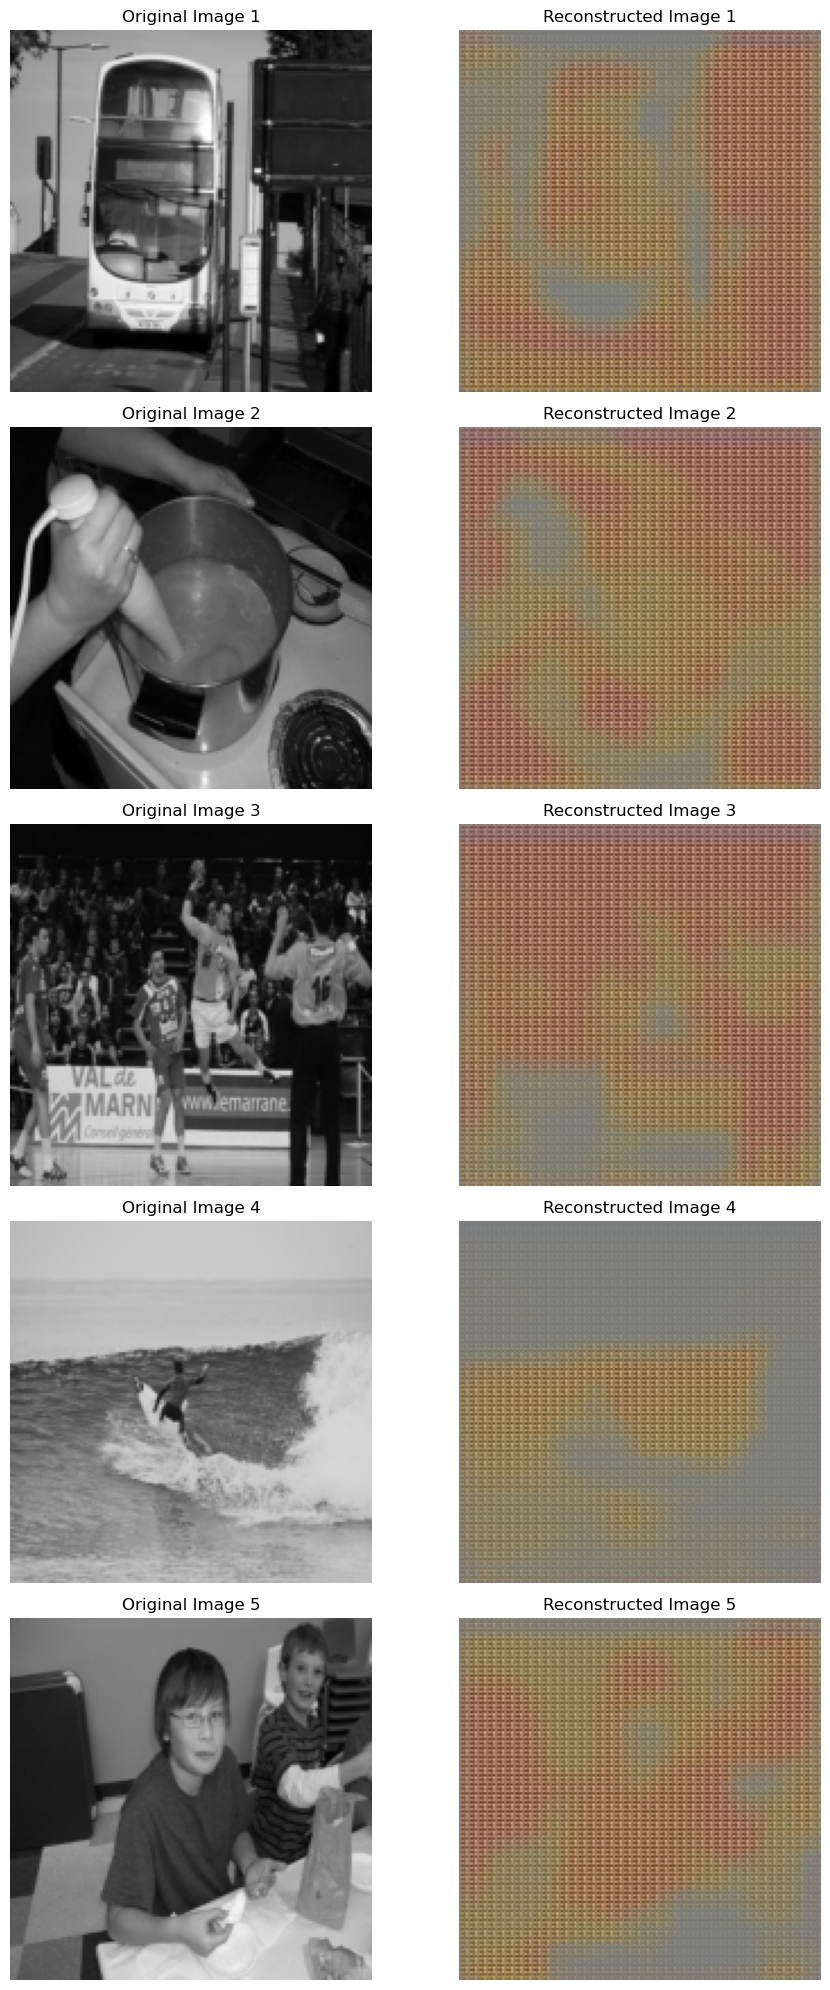

In [81]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

# Function to visualize the original and reconstructed images
def visualize_reconstruction(model, dataloader, device, num_images=5):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Visualize the first `num_images` images
            if i == 0:
                fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

                for j in range(num_images):
                    # Get the original and reconstructed images
                    original_img = inputs[j].cpu().numpy().transpose(1, 2, 0)  # Change shape from [C, H, W] to [H, W, C]
                    reconstructed_img = outputs[j].cpu().numpy().transpose(1, 2, 0)  # Same for the output

                    # Denormalize the images if required (uncomment if your images are normalized)
                    # original_img = original_img * 255.0  # If the images are normalized [0, 1]
                    # reconstructed_img = reconstructed_img * 255.0

                    # Plot original image
                    axes[j, 0].imshow(np.clip(original_img, 0, 1))
                    axes[j, 0].set_title(f"Original Image {j+1}")
                    axes[j, 0].axis('off')

                    # Plot reconstructed image
                    axes[j, 1].imshow(np.clip(reconstructed_img, 0, 1))
                    axes[j, 1].set_title(f"Reconstructed Image {j+1}")
                    axes[j, 1].axis('off')

                plt.tight_layout()
                plt.show()
                break  # Exit after visualizing the first batch

# Use the function to visualize reconstruction
visualize_reconstruction(model, test_loader, device)
